# Part 2 of 2: Creating a Model for SalePrice

After Part 1, we are ready to create a predictive model for SalePrice of the Ames Housing Data. We will be using regularized regression techniques, specifically the ridge model, and a random forest regression.

I would like to thank Alexandru Papiu for his tutorial on regularized linear regression. His Kaggle page can be found [here.](https://www.kaggle.com/apapiu)

Also great lecture notes from Standford University explaining Regularized Linear Regression can be found [here.](http://statweb.stanford.edu/~tibs/sta305files/Rudyregularization.pdf)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [4]:
df_alldata = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'],
                      df_test.loc[:,'MSSubClass':'SaleCondition']))

In [5]:
df_alldata.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


In [6]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

numerical_variables = df_alldata.dtypes[df_alldata.dtypes != "object"].index

skewed_variables = df_train[numerical_variables].apply(lambda x: skew(x.dropna())) 
skewed_variables = skewed_variables[skewed_variables > 0.75]
skewed_variables = skewed_variables.index

df_alldata[skewed_variables] = np.log1p(df_alldata[skewed_variables])

In [7]:
df_alldata = pd.get_dummies(df_alldata)

# Regularized Linear Regression: Ridge Model

In [8]:
df_alldata = df_alldata.fillna(df_alldata.mean())
x_train = df_alldata[:df_train.shape[0]]
x_test = df_alldata[df_train.shape[0]:]
y_train = df_train['SalePrice']

In [9]:
def rmse_cv(m):
    rmse= np.sqrt(-cross_val_score(m, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [10]:
alphas = [0.05,0.1,0.5,1,2,3,4,7,10,13,16]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'RMSE')

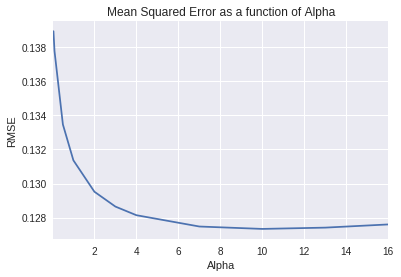

In [13]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot()
plt.title('Mean Squared Error as a function of Alpha')
plt.xlabel("Alpha")
plt.ylabel("RMSE")

In [14]:
cv_ridge.min()

0.12733734668670776

# Random Forest Regression 

In [15]:
regressor = RandomForestRegressor(n_estimators=300, random_state=0)
regressor.fit(x_train, y_train)
regressor.score(x_train, y_train)

0.98278548056881321

In [19]:
y_prediction = regressor.predict(x_test)

In [20]:
rmse_cv(regressor).mean()

0.1431306604995074